# Is something wrong with the Sgr cuts in Petersen & Peñarrubia (2021)?

## The basic idea
It would be a problem for the interpretation of Sgr as the driver of the PP21 fits if
1. The PP21 dataset returned the different result using a maximum likelihood methodology
2. The PP21 result didn't change if using a range of proposed Sgr cuts

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.interpolate import make_interp_spline

from scipy.optimize import minimize
from scipy.linalg import inv


In [2]:
# the coordinate transformation
def calculate_lambda_beta(ra, dec):
    """From Belokurov et al. 2014, appendix A"""
    alpha = np.radians(ra)
    delta = np.radians(dec)
    
    lambda_tilde = np.arctan2(
        -0.93595354 * np.cos(alpha) * np.cos(delta) - 0.31910658 * np.sin(alpha) * np.cos(delta) + 0.14886895 * np.sin(delta),
        0.21215555 * np.cos(alpha) * np.cos(delta) - 0.84846291 * np.sin(alpha) * np.cos(delta) - 0.48487186 * np.sin(delta)
    )
    
    beta_tilde = -np.arcsin(
        0.28103559 * np.cos(alpha) * np.cos(delta) - 0.42223415 * np.sin(alpha) * np.cos(delta) + 0.86182209 * np.sin(delta)
    )
    
    return np.degrees(lambda_tilde), np.degrees(beta_tilde)



In [3]:
def galactic_to_cartesian(ell, b):
    # Convert Galactic coordinates (ell, b) to Cartesian coordinates (x, y, z)
    x = np.cos(b) * np.cos(ell)
    y = np.cos(b) * np.sin(ell)
    z = np.sin(b)
    return np.stack((x, y, z), axis=-1)  # Shape (..., 3)

def cos_theta(ell1, b1, ell2, b2):
    # Convert each point from Galactic (l, b) to Cartesian coordinates
    p1 = galactic_to_cartesian(ell1, b1)
    p2 = galactic_to_cartesian(ell2, b2)
    
    # Compute the dot product (sum of element-wise products along the last axis)
    dot_products = np.sum(p1 * p2, axis=-1)
    
    # Compute norms for each point
    norms1 = np.linalg.norm(p1, axis=-1)
    norms2 = np.linalg.norm(p2, axis=-1)
    
    # Compute cos(theta) for each pair
    cos_theta_vals = dot_products / (norms1 * norms2)
    return cos_theta_vals


# Define the negative log-likelihood function
def neg_log_likelihood(theta, x, y, sigma,model):
    """a standard gaussian likelihood"""
    model_pred = model(theta, x)
    return np.sum(np.log(2*np.pi*(theta[4]**2 + sigma**2)) + ((y - model_pred)**2 / (theta[4]**2 + sigma**2)))


def max_likelihood(x_data,y_obs,sigma_obs,model,theta_init,bounds=[(None, None), (None,None),(None,None),(-np.pi/2.,np.pi/2.),(0,None)], eps=1e-5):
    """
    Perform maximum likelihood estimation of the parameters of the model.
    
    Wrapping the boring parts of the likelihood estimation, and also making some pretty print statements."""

    # Minimize the negative log-likelihood using Nelder-Mead
    result = minimize(neg_log_likelihood, theta_init, args=(x_data, y_obs, sigma_obs,model), method='Nelder-Mead',bounds=bounds)

    # Get the optimized parameters
    theta_opt = result.x

    print('Mean log likelihood = {0:5.2f}'.format(neg_log_likelihood(theta_opt, x_data, y_obs, sigma_obs,model)/x_data.shape[1]))

    # Compute the Hessian for the negative log-likelihood
    hess = hessian(lambda t: neg_log_likelihood(t, x_data, y_obs, sigma_obs,model), theta_opt,eps=eps)

    # Estimate the uncertainties (covariance matrix)
    cov_matrix = inv(hess)

    # The uncertainties on the parameters are the square roots of the diagonal elements of the covariance matrix
    param_uncertainties = np.sqrt(np.abs(np.diag(cov_matrix)))

    if theta_opt[1] > 0:
        # invert the dipole
        print('Inverting dipole...')
        theta_opt[1] *= -1.
        theta_opt[2] -= np.pi
        theta_opt[3] = -theta_opt[3]
        print('Inverted Mean log likelihood = {0:5.2f}'.format(neg_log_likelihood(theta_opt, x_data, y_obs, sigma_obs,model)/x_data.shape[1]))


    print('l ={0:7.1f} \pm {1:5.1f} ({2:6.1f})'.format(np.degrees(theta_opt[2]),np.degrees(param_uncertainties[2]),np.degrees(theta_init[2])))
    print('b ={0:7.1f} \pm {1:5.1f} ({2:6.1f})'.format(np.degrees(theta_opt[3]),np.degrees(param_uncertainties[3]),np.degrees(theta_init[3])))
    print('vd={0:7.1f} \pm {1:5.1f} ({2:6.1f})'.format(theta_opt[1],param_uncertainties[1],theta_init[1]))
    print('vc={0:7.1f} \pm {1:5.1f} ({2:6.1f})'.format(theta_opt[0],param_uncertainties[0],theta_init[0]))
    print('s ={0:7.1f} \pm {1:5.1f} ({2:6.1f})'.format(theta_opt[4],param_uncertainties[4],theta_init[4]))

    return theta_opt,param_uncertainties,theta_init


# Compute the Hessian numerically using finite differences
#eps = np.sqrt(np.finfo(float).eps)


def hessian(func, x0, eps=1e-5):
    """
     I guess we can approximate the Hessian using second-order derivatives?
     it would be nice to use 
     hess_inv = result.hess_inv  # Only available for some minimisation methods; Nelder-Mead doesn't return it

     Other papers must not be using scipy? If a custom implementation, probably should be released to check for bugs
    """
    n = len(x0)
    hess = np.zeros((n, n))
    f0 = func(x0)
    
    for i in range(n):
        x1 = np.copy(x0)
        x1[i] += eps
        f1 = func(x1)
        
        for j in range(i, n):
            x2 = np.copy(x0)
            x2[j] += eps
            f2 = func(x2)
            
            x3 = np.copy(x0)
            x3[i] += eps
            x3[j] += eps
            f3 = func(x3)
            
            hess[i, j] = (f3 - f2 - f1 + f0) / (eps ** 2)
            if i != j:
                hess[j, i] = hess[i, j]
    
    return hess




In [4]:
# Define the model function
def dipole_model(theta, x):
    """
    theta[0] = vcompr
    theta[1] = vdipole
    theta[2] = lapex
    theta[3] = bapex"""
    return theta[0] + theta[1] * cos_theta(theta[2],theta[3],x[0],x[1])


def rotation_model(theta, x):
    """
    Model radial velocity induced by rotation on the sky.
    
    Parameters:
    theta[0] = vrot     # Maximum rotational speed
    theta[1] = l_rot    # Longitude of rotation axis
    theta[2] = b_rot    # Latitude of rotation axis
    
    x[0] = ell  # Longitude of the observed point
    x[1] = b    # Latitude of the observed point
    """
    vrot = theta[0]
    l_rot = theta[1]
    b_rot = theta[2]
    
    # Calculate cos(theta) between rotation axis and observed point on sky
    cos_theta_val = cos_theta(l_rot, b_rot, x[0], x[1])
    
    # Project the rotational velocity into the radial component
    return vrot * cos_theta_val

# Rotation is exactly the same as a dipole, just with a free rotation axis. This would seem to be a problem.

In [5]:
# Define a custom spline function to not extrapolate
# Other works don't seem to be using the spline implementation in scipy. Or I misunderstood the data? This is a simple cubic spline and it follows the data wiggles.
# anyway I also needed to not extrapolate and this seemed easiest.

def safe_spline(x, y):
    spline = make_interp_spline(x, y, k=3)
    
    def spline_with_nan(x_new):
        y_new = spline(x_new)
        y_new[(x_new < x.min()) | (x_new > x.max())] = np.nan
        return y_new
    
    return spline_with_nan


## Step 0: Kick the tyres on the model and fit

Plan:
1. Make sure the on-sky model reproduces the expected structure
2. Make sure a fit can recover the input parameters from a set of points

Throughout, we're going to assume that if the returned value is a boundary, we're in a funky spot in likelihood space and we'll redo with a different initial guess (very hacky).

Mean log likelihood = 11.86
l =  -77.3 \pm   2.9 ( -72.7)
b =  -51.8 \pm   1.8 ( -52.9)
vd=  -35.4 \pm   0.9 ( -34.0)
vc=  -22.8 \pm   0.6 ( -23.5)
s =   90.8 \pm   0.4 (  90.5)


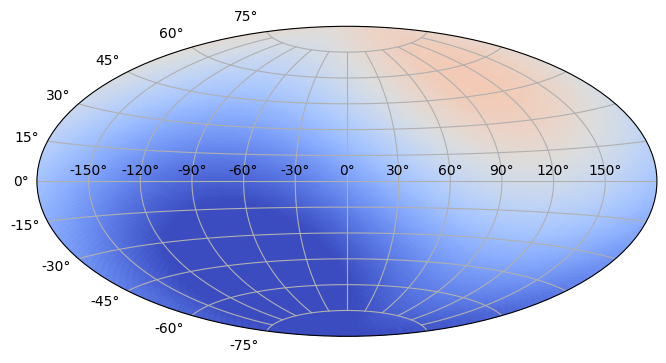

In [6]:
# Generate points evenly spaced on the unit sphere. Not really what the data is, but this is just a test.
num_points = 10000 # something in the range of stars that DESI has. 
# oh, this is the total at all distances. the actual used number is 675, lol, bad reading on my part. Let's go with 10k because 675 results in miserable parameter recovery (exercise to the reader)
#num_points = 675

indices = np.arange(0, num_points, dtype=float) + 0.5
phi = np.arccos(1 - 2*indices/num_points)
theta = np.pi * (1 + 5**0.5) * indices

# Convert spherical coordinates to Cartesian coordinates
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Convert Cartesian coordinates to galactic coordinates for Aitoff projection
lambda_ = np.arctan2(y, x)
beta_ = np.arcsin(z / np.sqrt(x**2 + y**2 + z**2))

# use the best-fit values for the model from a DESI paper
theta_DESI = [-23.5,-34.0,np.radians(-72.7),np.radians(-52.9),90.5]

# now apply the mean velocity model to all points
cvals = dipole_model(theta_DESI, [lambda_,beta_])

x_data    = np.array([lambda_,beta_])  # Coordinates
y_obs     = cvals + np.random.normal(0, theta_DESI[4], cvals.size)  # inject the fit gaussian width at this point
sigma_obs = np.abs(np.random.normal(1.,0.5,size=y_obs.size))#np.ones(y_obs.size)  # 'Uncertainties'. It doesn't seem to matter if constant or an approximation to (reported) DESI values.
# do the fit
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_DESI)

# make a random subselection of the points? this is good for uncertainty testing but we'll just keep everybody for now
subselection = np.random.choice(np.arange(lambda_.size),size=int(lambda_.size/10.))
#theta_opt,param_uncertainties,theta_init = max_likelihood(x_data[:,subselection],y_obs[subselection],sigma_obs[subselection],dipole_model,theta_DESI)

# can apply an observation set of cuts here if we want
galactic_coord = SkyCoord(l=lambda_*u.rad, b=beta_*u.rad, frame='galactic')
equatorial_coord = galactic_coord.transform_to('icrs')
criteria = (equatorial_coord.dec.deg > -20) & (np.abs(np.degrees(beta_)) > 10) # I don't know what DESI's actual cuts are, but this is a reasonable guess?
#theta_opt,param_uncertainties,theta_init = max_likelihood(x_data[:,criteria],y_obs[criteria],sigma_obs[criteria],dipole_model,theta_DESI)



# plot the model to make sure it matches the expected on-sky radial velocity map
plt.figure(figsize=(8, 4.2))
plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.scatter(lambda_, beta_, c=cm.coolwarm((cvals+50)/100.),s=50)
#plt.scatter(lambda_[criteria], beta_[criteria], c=cm.coolwarm((cvals[criteria]+50)/100.),s=50)
#plt.scatter(lambda_[subselection], beta_[subselection], c=cm.coolwarm((cvals[subselection]+50)/100.),s=50)
plt.show()

Uncertainties seem to be a underestimated, but that's just a little annoying rather than very problematic (if you don't think they are, draw random samples again. you'll get a bunch of uncertainty underestimates). Probably good to explore this in the paper, though. It wouldn't be hard: just resample random draws a thousand times and see if the uncertainties on fit parameters are Gaussian (and with what standard deviation). To be fair, the uncertainties are dependent on the finite differences I used to compute the Hessian, which is also not great, and could be something in my Hessian implementation?

### Everything seems to be working:
1. Model looks like Figure 8
2. Minimiser recovered the input parameters
3. Uncertainties are working?

so let's move on to some data stuff.

## Step 1: Bring in Hernitschek+17 Sgr track data

...and then make splines out of it so we can use it to cut out Sgr stars.

In [7]:
# I pulled the tables from the .tex, and then just added a short header. Nothing fancy.
#HL = pd.read_csv('Hernitschek_leading.txt', sep='&')
#HT = pd.read_csv('Hernitschek_trailing.txt', sep='&')


# actually just write the data here, it's easier than wrangling files
HT = dict()
HT['L'] = np.array([105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225,235, 245, 255, 265, 275, 285, 295, 305, 315, 325, 335, 345, 355]) # Sgr Lambda values
HT['Dsgr'] = np.array([55.4  , 62.3  , 57.2  , 66.9  , 81.3  , 83.1  , 89.02 , 92.98 ,
       86.7  , 60.   , 53.   , 43.15 , 36.55 , 31.17 , 28.41 , 25.57 ,
       24.7  , 18.   , 20.34 , 21.2  , 20.8  , 21.66 , 22.   , 20.1  ,
       19.7  , 27.605]) # Heliocentric distance to the stream
HT['Ssgr'] = np.array([ 3.2  ,  3.5  ,  2.3  ,  5.8  ,  6.1  ,  5.2  ,  5.13 ,  8.99 ,
       10.5  ,  2.8  ,  6.78 ,  6.65 ,  6.28 ,  6.16 ,  4.66 ,  5.14 ,
        4.86 ,  7.7  ,  4.44 ,  4.7  ,  5.17 ,  4.84 ,  4.41 ,  5.3  ,
        6.43 ,  1.245]) # Stream depth


HL = dict()
HL['L'] = np.array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155])
HL['Dsgr'] = np.array([28.83, 14.3 , 34.14, 36.65, 45.94, 50.5 , 52.59, 49.19, 46.22,
       40.59, 34.8 , 31.19, 25.9 , 21.34, 19.66, 16.2 ])
HL['Ssgr'] = np.array([1.621, 2.8  , 2.8  , 4.1  , 3.68 , 3.33 , 4.52 , 3.75 , 4.66 ,
       3.88 , 6.3  , 3.08 , 5.   , 2.7  , 2.05 , 3.4  ])


Text(0, 0.5, 'Distance (kpc)')

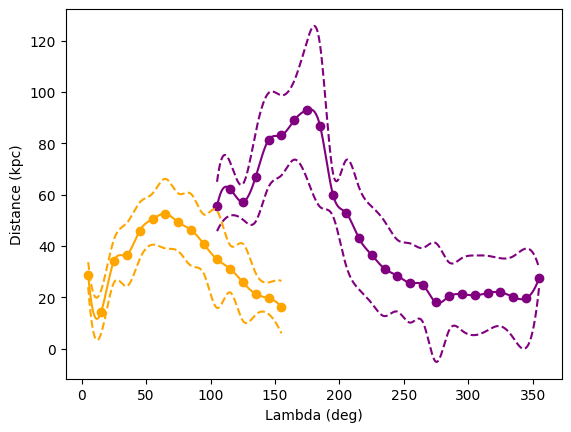

In [8]:
# we need the .values if using the file reads
#x = HT['L'].astype(float).values
#y = HT['Dsgr'].values
#z = HT['Ssgr'].values

x = HT['L'].astype(float)#.values
y = HT['Dsgr']#.values
z = HT['Ssgr']#.values

y = y[x.argsort()]
z = z[x.argsort()]
x = x[x.argsort()]

# compute a spline for the position of the stream
tposspline = safe_spline(x, y)

# compute a spline for the depth of the stream
tdepthspline = safe_spline(x, z)

tx_spline = np.linspace(min(x), max(x), 1000)
plt.scatter(x, y, color='purple')
plt.plot(tx_spline, tposspline(tx_spline), color='purple')
plt.plot(tx_spline, tposspline(tx_spline)+3*tdepthspline(tx_spline), color='purple',linestyle='dashed')
plt.plot(tx_spline, tposspline(tx_spline)-3*tdepthspline(tx_spline), color='purple',linestyle='dashed')

x = HL['L'].astype(float)#.values
y = HL['Dsgr']#.values
z = HL['Ssgr']#.values

y = y[x.argsort()]
z = z[x.argsort()]
x = x[x.argsort()]

lposspline = safe_spline(x, y)
ldepthspline = safe_spline(x, z)

lx_spline = np.linspace(min(x), max(x), 1000)
plt.scatter(x, y, color='orange')
plt.plot(lx_spline, lposspline(lx_spline), color='orange')
plt.plot(lx_spline, lposspline(lx_spline)+3*ldepthspline(lx_spline), color='orange',linestyle='dashed')
plt.plot(lx_spline, lposspline(lx_spline)-3*ldepthspline(lx_spline), color='orange',linestyle='dashed')
plt.xlabel('Lambda (deg)')
plt.ylabel('Distance (kpc)')

This looks(?) like the Hernitschek figure, so let's roll with it!

## Step 2: Look at PP21 data

### Step 2.1: Bring in the raw data from GitHub (it's all processed and public, so anyone can actually do this!)

In [9]:

# this is the exact set of BHBs used for fitting in YPP24: this is Gaia DR2, but we're not using proper motions, so it doesn't matter
dfname = 'https://raw.githubusercontent.com/michael-petersen/ReflexMotion/refs/heads/main/data/observations/BHBs_cartesian_heliocentric_sgr.txt'

# actually use this one because it's been 'cleaned' of BSs (but it doesn't matter strongly)
dfname = 'https://raw.githubusercontent.com/michael-petersen/ReflexMotion/refs/heads/main/processed/BHBs_cartesian_heliocentric_lancasterremoved.txt'
d3 = np.loadtxt(dfname,skiprows=1)
PP21 = dict()
cats = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']
for ic,c in enumerate(cats):
    PP21[c] = d3[:,ic]


# make the Sgr conversion
galactic_coords = SkyCoord(l=PP21['l']*u.degree, b=PP21['b']*u.degree, frame='galactic')
equatorial_coords = galactic_coords.icrs
PP21['Lambda'],PP21['Beta'] = calculate_lambda_beta(equatorial_coords.ra.degree, equatorial_coords.dec.degree)
# Convert Lambda < 0 to have +360
PP21['Lambda'] = np.where(PP21['Lambda'] < 0, PP21['Lambda'] + 360, PP21['Lambda'])

# make the angular momentum
PP21['Lx'] = PP21['y']*PP21['vz'] - PP21['z']*PP21['vy']
PP21['Ly'] = PP21['z']*PP21['vx'] - PP21['x']*PP21['vz']
PP21['Lz'] = PP21['x']*PP21['vy'] - PP21['y']*PP21['vx']

# observed heliocentric velocities need to be converted to lsr
# peculiar motion of the sun
vpec = np.array([11.1, 12.24, 7.25])
vrot = 232.
PP21['vlsr'] = PP21['vlos'] + (vpec[0])*np.cos(np.radians(PP21['l']))*np.cos(np.radians(PP21['b'])) + (vpec[1]+vrot)*np.sin(np.radians(PP21['l']))*np.cos(np.radians(PP21['b'])) + (vpec[2])*np.sin(np.radians(PP21['b']))

# set to the same range as everything else: (-180,180)
PP21['l'][PP21['l'] >180] -= 360

# Galactocentric distance(ish)
PP21['dgal'] = np.sqrt(PP21['x']**2 + PP21['y']**2 + PP21['z']**2)


### Step 2.2: Setup various Sgr removal criteria

First, a list of criteria.

In [10]:
sgrdepthcut = 3

# a criteria based on Sgr geometry
criteria = np.abs(PP21['Beta']<15) & \
           ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < sgrdepthcut ) |\
             (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < sgrdepthcut )) | (PP21['dgal']<50)

# add (PP21['d']<40) | to get a distance cut

# the PP21 criteria
sgrcen = [605, -4515, -1267]
sgrballcut = 3000
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<50)

# PP21 + Sgr geometry
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<50) | (np.abs(PP21['Beta']<15) & \
           ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < sgrdepthcut ) |\
             (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < sgrdepthcut )))


# no criteria
#criteria = (np.abs(PP21['Beta']) < 0.) | (PP21['d']<40)

# this is the Johnson+21 criteria
#criteria = PP21['Ly'] < -2500 - 0.3*PP21['Lz']

# Johnson+21 + Sgr geometry (slightly more clever in what it doesn't eliminate)
#criteria = (PP21['Ly'] < -2500 - 0.3*PP21['Lz']) & np.abs(PP21['Beta']<15) & ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < 3) | (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < 3))


Let's just look at PP21 data for fun with the Sgr geometry criteria applied

Stars for fit=72, total stars=4442, ejected stars=4514


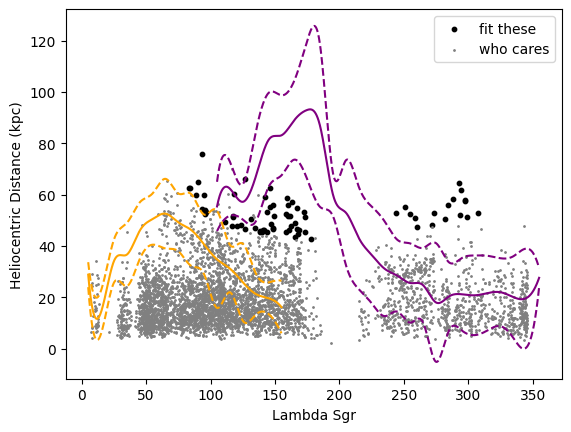

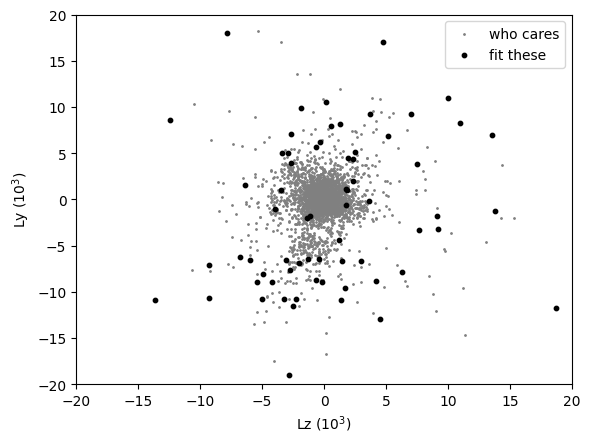

In [11]:

def plot_data_checks(PP21,criteria):

    # plot the background
    plt.scatter(PP21['Lambda'][~criteria], PP21['d'][~criteria], c='black', s=10.,label='fit these')

    fig = plt.figsize=(3,3)

    plt.scatter(PP21['Lambda'][criteria], PP21['d'][criteria], c='grey', s=1.,label='who cares')

    # trailing
    plt.plot(tx_spline, tposspline(tx_spline), color='purple')
    plt.plot(tx_spline, tposspline(tx_spline)+3*tdepthspline(tx_spline), color='purple',linestyle='dashed')
    plt.plot(tx_spline, tposspline(tx_spline)-3*tdepthspline(tx_spline), color='purple',linestyle='dashed')

    # leading
    plt.plot(lx_spline, lposspline(lx_spline), color='orange')
    plt.plot(lx_spline, lposspline(lx_spline)+3*ldepthspline(lx_spline), color='orange',linestyle='dashed')
    plt.plot(lx_spline, lposspline(lx_spline)-3*ldepthspline(lx_spline), color='orange',linestyle='dashed')

    plt.legend()
    plt.xlabel('Lambda Sgr')
    plt.ylabel('Heliocentric Distance (kpc)')

    plt.figure()
    fig = plt.figsize=(3,3)
    plt.scatter(PP21['Lz'][criteria]/1000,PP21['Ly'][criteria]/1000,color='grey',s=1.,label='who cares')
    plt.scatter(PP21['Lz'][~criteria]/1000,PP21['Ly'][~criteria]/1000,color='black',s=10.,label='fit these')
    plt.axis([-20,20,-20,20])
    plt.xlabel('Lz ($10^3$)')
    plt.ylabel('Ly ($10^3$)')
    plt.legend()

    # ejected, total stars
    print('Stars for fit={}, total stars={}, ejected stars={}'.format(PP21['Lambda'].size-PP21['Lambda'][criteria].size,PP21['Lambda'][criteria].size,PP21['Lambda'].size))

    #plt.figure();plt.figure(figsize=(8, 4.2));plt.subplot(111, projection="aitoff")
    #plt.scatter(np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria]), c=cm.coolwarm((PP21['vlsr'][~criteria]+200)/400.),s=50)
    #plt.grid(True);plt.show()


# use this if you'd like to see any data visualised below
plot_data_checks(PP21,criteria)

### Step 2.3: Compute the likelihood for the model

In [12]:
# try the data fit

# Initial guess for parameters (theta)
theta_init = np.array([-10,-30,0.,0.2,90])  

# this is what was applied above, but just to check...
# PP21 + Sgr geometry
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<50) | (np.abs(PP21['Beta']<15) & \
           ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < sgrdepthcut ) |\
             (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < sgrdepthcut )))

print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init,eps=1.e-4) # eps needs to be tuned if dgal limit is 40, because likelihood seems to be really shallow

theta_opt = np.array([-22,-26,np.radians(59),np.radians(-42),91])
print('(comparison to PP21 combined sample values) Mean log likelihood = {0:5.2f}'.format(neg_log_likelihood(theta_opt, x_data, y_obs, sigma_obs,dipole_model)/x_data.shape[1]))


Fitting 72 stars.
Mean log likelihood = 11.69
l =  -72.7 \pm  20.2 (   0.0)
b =  -43.4 \pm  12.8 (  11.5)
vd=  -66.7 \pm  25.6 ( -30.0)
vc=  -19.6 \pm  12.1 ( -10.0)
s =   82.6 \pm   5.0 (  90.0)
(comparison to PP21 combined sample values) Mean log likelihood = 11.78


The DESI collaboration finds 

| Parameter | Value             |
|-----------|-------------------|
| l         | -72.7 ± 21.2      |
| b         | -52.9 ± 12.6      |
| vd        | -34.0 ± 10.6      |
| vc        | -23.5 ±  4.6      |
| s         |  90.5 ±  2.5      |

So that's basically the same. Cool! It's an Sgr cleaning problem then, right?



Let's check what the PP21 stupid angular momentum ball would have given:

In [13]:
# PP21 criteria
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<40)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,-30,0.,-0.1,90]) 
#theta_init = np.array([-10,30,0.,0.3,120])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init,eps=1e-4)
#plot_data_checks(PP21,criteria)

Fitting 298 stars.
Mean log likelihood = 11.91
l =  -36.9 \pm  38.3 (   0.0)
b =  -64.7 \pm  15.9 (  -5.7)
vd=  -33.2 \pm  10.4 ( -30.0)
vc=  -28.3 \pm   6.5 ( -10.0)
s =   92.8 \pm   2.7 (  90.0)


Uh oh. That's not that different within uncertainties! And it definitely isn't what PP21 got. That's not good, since the interpretation of Sgr contamination hinges on the PP21 Sgr cleaning being what led us to have an apex in the 'wrong' quadrant. This apex is in the 'right' quadrant (the quadrant the LMC resides in).

(I 'cheated' here and lowered the distance to 40kpc because 50+kpc didn't converge reliably; using 40+kpc with the Sgr geometry cut doesn't make a difference, really.)

What about the other Sgr cut, from Johnson?

In [15]:
# this is the Johnson criteria
criteria = (PP21['Ly'] < -2500 - 0.3*PP21['Lz'])| (PP21['dgal']<40)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)
#plot_data_checks(PP21,criteria)

# YPP24 format is
# Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
# Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
rows = ['x','y','z','vx','vy','vz','l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']

f = open('../data/observations/DR3/BHB_dr2_J21sgr_40+.txt','w')
for row in rows:
    for entry in PP21[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()

Fitting 197 stars.
Mean log likelihood = 11.98
l =  -20.8 \pm  25.1 (   0.0)
b =  -37.4 \pm  17.4 (  -5.7)
vd=  -28.8 \pm  15.2 ( -30.0)
vc=  -19.3 \pm  10.9 ( -10.0)
s =   96.2 \pm   3.2 (  90.0)


Again statistically similar to the values above, and not consistent with the values reported in PP21.

But surely the Sgr cut must be helpful, right?

In [16]:
# no Sgr cut at all
criteria =  (PP21['dgal']<40)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,30,0.,0.1,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)
#plot_data_checks(PP21,criteria)


Fitting 320 stars.
Mean log likelihood = 11.89
l =  -40.7 \pm  25.4 (   0.0)
b =  -56.0 \pm  12.9 (   5.7)
vd=  -35.4 \pm  10.6 (  30.0)
vc=  -30.7 \pm   6.8 ( -10.0)
s =   91.8 \pm   2.6 (  90.0)


Ah. Nope, the values are within the uncertainties if we eliminate ZERO Sgr stars.

One liberty I did take was to go back down to 40 kpc; when cutting at 50kpc, it was _really_ hard to find the maximum likelihood solution.

### Sgr was a nice scapegoat, but it seems like the radial velocity only model is too simple.

Also, the maximum likelihood fit is very sensitive to the initial conditions, which should give pause as to how well the likelihood space is being explored.

But wait! I can hear you say. Maybe the BHBs are just a problematic sample, after all, there aren't many of them available.

Good idea! 

### Let's pull in the K giant data from the PP21 repository and see what we get.

In [17]:

# try the raw PP21 data from GitHub
dfname = 'https://raw.githubusercontent.com/michael-petersen/ReflexMotion/refs/heads/main/processed/KGiants_cartesian_heliocentric_sgr.txt'
d3 = np.loadtxt(dfname,skiprows=1)
PP21 = dict()
cats = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']
for ic,c in enumerate(cats):
    PP21[c] = d3[:,ic]

# make the Sgr conversion
galactic_coords = SkyCoord(l=PP21['l']*u.degree, b=PP21['b']*u.degree, frame='galactic')
equatorial_coords = galactic_coords.icrs
PP21['Lambda'],PP21['Beta'] = calculate_lambda_beta(equatorial_coords.ra.degree, equatorial_coords.dec.degree)
# Convert Lambda < 0 to have +360
PP21['Lambda'] = np.where(PP21['Lambda'] < 0, PP21['Lambda'] + 360, PP21['Lambda'])

# make the angular momentum
PP21['Lx'] = PP21['y']*PP21['vz'] - PP21['z']*PP21['vy']
PP21['Ly'] = PP21['z']*PP21['vx'] - PP21['x']*PP21['vz']
PP21['Lz'] = PP21['x']*PP21['vy'] - PP21['y']*PP21['vx']

# observed heliocentric velocities need to be converted to lsr
# peculiar motion of the sun
vpec = np.array([11.1, 12.24, 7.25])
vrot = 232.
PP21['vlsr'] = PP21['vlos'] + (vpec[0])*np.cos(np.radians(PP21['l']))*np.cos(np.radians(PP21['b'])) + (vpec[1]+vrot)*np.sin(np.radians(PP21['l']))*np.cos(np.radians(PP21['b'])) + (vpec[2])*np.sin(np.radians(PP21['b']))

# set to the same range as everything else: (-180,180)
PP21['l'][PP21['l'] >180] -= 360

# Galactocentric distance
PP21['dgal'] = np.sqrt(PP21['x']**2 + PP21['y']**2 + PP21['z']**2)


In [18]:
# no (additional) Sgr cut at all
criteria =  (PP21['dgal']<50)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,-30,0.,-0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)
#plot_data_checks(PP21,criteria)

"""
f = open('../data/observations/DR3/KGiant_dr2_nosgr_50+.txt','w')
for row in rows:
    for entry in PP21[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()
"""

Fitting 284 stars.
Mean log likelihood = 11.72
l =  -61.5 \pm  19.1 (   0.0)
b =  -56.1 \pm   6.6 ( -11.5)
vd=  -41.2 \pm   9.2 ( -30.0)
vc=  -10.8 \pm   4.3 ( -10.0)
s =   84.8 \pm   2.5 (  90.0)


"\nf = open('../data/observations/DR3/KGiant_dr2_nosgr_50+.txt','w')\nfor row in rows:\n    for entry in PP21[row][~criteria]:\n        f.write(str(entry)+' ')\n    f.write('\n')\n\nf.close()\n"

Right. So with no additional Sgr cleaning, we get very similar values to DESI. That's kind of curious. 

What about with the PP21 cuts applied?

In [19]:
# PP21 criteria
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<40)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,30,0.,0.2,90])  
theta_init = np.array([-10,-30,0.,-0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)
#plot_data_checks(PP21,criteria)

"""
f = open('../data/observations/DR3/KGiant_dr2_PP21sgr_40+.txt','w')
for row in rows:
    for entry in PP21[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()
"""

Fitting 558 stars.
Mean log likelihood = 11.90
l =    0.3 \pm  14.5 (   0.0)
b =  -90.0 \pm   0.0 ( -11.5)
vd=  -19.1 \pm   4.6 ( -30.0)
vc=  -13.4 \pm   3.1 ( -10.0)
s =   92.7 \pm   2.0 (  90.0)


"\nf = open('../data/observations/DR3/KGiant_dr2_PP21sgr_40+.txt','w')\nfor row in rows:\n    for entry in PP21[row][~criteria]:\n        f.write(str(entry)+' ')\n    f.write('\n')\n\nf.close()\n"

The values are unchanged(ish).

Let's check the big one:

In [20]:
# PP21 + Sgr geometry
criteria = (np.sqrt((PP21['Lx']-sgrcen[0])**2 + (PP21['Ly']-sgrcen[1])**2 + (PP21['Lz']-sgrcen[2])**2) < sgrballcut) | (PP21['dgal']<50) | (np.abs(PP21['Beta']<15) & \
           ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < sgrdepthcut) |\
             (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < sgrdepthcut)))

criteria =  (PP21['dgal']<40) | (np.abs(PP21['Beta']<15) & \
           ((np.abs(PP21['d']-lposspline(PP21['Lambda']))/ldepthspline(PP21['Lambda']) < sgrdepthcut) |\
             (np.abs(PP21['d']-tposspline(PP21['Lambda']))/tdepthspline(PP21['Lambda']) < sgrdepthcut)))

print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,30,0.,0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init,eps=1e-4) # boost Hessian step massively, this likely underestimates uncertainties
#plot_data_checks(PP21,criteria)

"""
f = open('../data/observations/DR3/KGiant_dr2_B24sgr_40+.txt','w')
for row in rows:
    for entry in PP21[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()
"""

Fitting 343 stars.
Mean log likelihood = 11.95
Inverting dipole...
Inverted Mean log likelihood = 11.95
l =  -92.4 \pm  17.8 (   0.0)
b =  -32.3 \pm   8.2 (  11.5)
vd=  -37.9 \pm  11.6 (  30.0)
vc=   -8.9 \pm   5.6 ( -10.0)
s =   95.1 \pm   2.6 (  90.0)


"\nf = open('../data/observations/DR3/KGiant_dr2_B24sgr_40+.txt','w')\nfor row in rows:\n    for entry in PP21[row][~criteria]:\n        f.write(str(entry)+' ')\n    f.write('\n')\n\nf.close()\n"

Cool, same values whether we make an aggressive Sgr cut or not. Something wrong with the uncertainties here, probably a Hessian determination issue, but also this is with a fairly small number of stars, so also probably not great.

Sure, why not, let's check the Johnson cut.

In [21]:
# this is the Johnson criteria
criteria = (PP21['Ly'] < -2500 - 0.3*PP21['Lz'])| (PP21['dgal']<50)
print('Fitting {} stars.'.format(PP21['l'][~criteria].size))
x_data    = np.array([np.radians(PP21['l'][~criteria]),np.radians(PP21['b'][~criteria])])
y_obs     = PP21['vlsr'][~criteria]  # Observed values
sigma_obs = PP21['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?

theta_init = np.array([-10,30,0.,0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)


Fitting 165 stars.
Mean log likelihood = 11.73
Inverting dipole...
Inverted Mean log likelihood = 11.73
l =  -93.5 \pm  26.5 (   0.0)
b =  -21.0 \pm  12.4 (  11.5)
vd=  -31.2 \pm  20.5 (  30.0)
vc=    8.5 \pm   8.0 ( -10.0)
s =   85.0 \pm   3.3 (  90.0)


Nice. Similar, but the compression velocity is off (not super surprising given that this cut eliminates a full third of the sky).

### Seems like we can definitely conclude Sgr is not the issue.

### It might be a simplicity of the model issue?

In [22]:
# Incidentally, this is how you would get the same K-giant data from YPP24. You'll have to ask for BHBs, it seems, but they are available.
"""
Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
Columns 13-17: distance_error, vlos_error, mul_error, mub_error, proper motion correlation
"""

# this is the data for between 40-50 kpc from the sun
dfname = 'https://raw.githubusercontent.com/RYaaqib/reflexcalc/refs/heads/main/processed_real/binned_sgr_4bin/KG/KGiant_edr3_metal_sgr_20_2.txt'
d1 = np.loadtxt(dfname)

# this is the data for 50+ kpc from the sun
dfname = 'https://raw.githubusercontent.com/RYaaqib/reflexcalc/refs/heads/main/processed_real/binned_sgr_4bin/KG/KGiant_edr3_metal_sgr_20_3.txt'
d2 = np.loadtxt(dfname)

YPP24 = dict()
cats = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']
for ic,c in enumerate(cats):
    YPP24[c] = np.concatenate([d1[ic],d2[ic]])


# make the Sgr conversion
galactic_coords = SkyCoord(l=YPP24['l']*u.degree, b=YPP24['b']*u.degree, frame='galactic')
equatorial_coords = galactic_coords.icrs
YPP24['Lambda'],YPP24['Beta'] = calculate_lambda_beta(equatorial_coords.ra.degree, equatorial_coords.dec.degree)
# Convert Lambda < 0 to have +360
YPP24['Lambda'] = np.where(YPP24['Lambda'] < 0, YPP24['Lambda'] + 360, YPP24['Lambda'])

# make the angular momentum
YPP24['Lx'] = YPP24['y']*YPP24['vz'] - YPP24['z']*YPP24['vy']
YPP24['Ly'] = YPP24['z']*YPP24['vx'] - YPP24['x']*YPP24['vz']
YPP24['Lz'] = YPP24['x']*YPP24['vy'] - YPP24['y']*YPP24['vx']

# observed heliocentric velocities need to be converted to lsr
# peculiar motion of the sun
vpec = np.array([11.1, 12.24, 7.25])
vrot = 232.
YPP24['vlsr'] = YPP24['vlos'] + (vpec[0])*np.cos(np.radians(YPP24['l']))*np.cos(np.radians(YPP24['b'])) + (vpec[1]+vrot)*np.sin(np.radians(YPP24['l']))*np.cos(np.radians(YPP24['b'])) + (vpec[2])*np.sin(np.radians(YPP24['b']))

# set to the same range as everything else: (-180,180)
YPP24['l'][YPP24['l'] >180] -= 360

# Galactocentric distance(ish)
YPP24['dgal'] = np.sqrt(YPP24['x']**2 + YPP24['y']**2 + YPP24['z']**2)

In [23]:
# print the data to a file so we can use it in the future
# PP21 
#  | 
criteria = (YPP24['dgal']<40) | (np.sqrt((YPP24['Lx']-sgrcen[0])**2 + (YPP24['Ly']-sgrcen[1])**2 + (YPP24['Lz']-sgrcen[2])**2) < sgrballcut)

print('Fitting {} stars.'.format(YPP24['l'][~criteria].size))
x_data    = np.array([np.radians(YPP24['l'][~criteria]),np.radians(YPP24['b'][~criteria])])
y_obs     = YPP24['vlsr'][~criteria]  # Observed values
sigma_obs = YPP24['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?


theta_init = np.array([-10,30,0.,-0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)

# YPP24 format is
# Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
# Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
rows = ['x','y','z','vx','vy','vz','l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']

f = open('../data/observations/DR3/KGiant_YPP24sgr_40+.txt','w')
for row in rows:
    for entry in YPP24[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()

Fitting 531 stars.
Mean log likelihood = 11.91
Inverting dipole...
Inverted Mean log likelihood = 11.91
l =  -98.1 \pm  17.3 (   0.0)
b =  -44.3 \pm   8.9 ( -11.5)
vd=  -46.1 \pm  17.7 (  30.0)
vc=  -16.8 \pm   5.8 ( -10.0)
s =   93.3 \pm   2.0 (  90.0)


In [24]:
# print the data to a file so we can use it in the future
# PP21 + Sgr geometry
# (np.sqrt((YPP24['dgal']['Lx']-sgrcen[0])**2 + (YPP24['dgal']['Ly']-sgrcen[1])**2 + (YPP24['dgal']['Lz']-sgrcen[2])**2) < sgrballcut) | 
criteria = (YPP24['dgal']<40) | (np.abs(YPP24['Beta']<15) & \
           ((np.abs(YPP24['d']-lposspline(YPP24['Lambda']))/ldepthspline(YPP24['Lambda']) < sgrdepthcut ) |\
             (np.abs(YPP24['d']-tposspline(YPP24['Lambda']))/tdepthspline(YPP24['Lambda']) < sgrdepthcut )))

print('Fitting {} stars.'.format(YPP24['l'][~criteria].size))
x_data    = np.array([np.radians(YPP24['l'][~criteria]),np.radians(YPP24['b'][~criteria])])
y_obs     = YPP24['vlsr'][~criteria]  # Observed values
sigma_obs = YPP24['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?


theta_init = np.array([-10,30,0.,-0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)

# YPP24 format is
# Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
# Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
rows = ['x','y','z','vx','vy','vz','l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']

f = open('../data/observations/DR3/KGiant_B24sgr_40+.txt','w')
for row in rows:
    for entry in YPP24[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()

Fitting 319 stars.
Mean log likelihood = 11.97
Inverting dipole...
Inverted Mean log likelihood = 11.97
l =  -94.8 \pm  20.2 (   0.0)
b =  -35.9 \pm   9.3 ( -11.5)
vd=  -35.9 \pm   9.6 (  30.0)
vc=   -6.8 \pm   5.2 ( -10.0)
s =   96.1 \pm   2.7 (  90.0)


In [25]:
# NO Sgr cut
criteria = (YPP24['dgal']<50)

print('Fitting {} stars.'.format(YPP24['l'][~criteria].size))
x_data    = np.array([np.radians(YPP24['l'][~criteria]),np.radians(YPP24['b'][~criteria])])
y_obs     = YPP24['vlsr'][~criteria]  # Observed values
sigma_obs = YPP24['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?


theta_init = np.array([-10,30,0.,-0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)

# YPP24 format is
# Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
# Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
rows = ['x','y','z','vx','vy','vz','l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']

f = open('../data/observations/DR3/KGiant_nosgr_50+.txt','w')
for row in rows:
    for entry in YPP24[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()

Fitting 255 stars.
Mean log likelihood = 11.77
l =  -69.6 \pm  27.5 (   0.0)
b =  -60.8 \pm  14.1 ( -11.5)
vd=  -38.4 \pm   9.5 (  30.0)
vc=   -6.6 \pm   6.9 ( -10.0)
s =   86.9 \pm   2.8 (  90.0)


In [26]:
criteria = (YPP24['Ly'] < -2500 - 0.3*YPP24['Lz'])| (YPP24['dgal']<40)
print('Fitting {} stars.'.format(YPP24['l'][~criteria].size))
x_data    = np.array([np.radians(YPP24['l'][~criteria]),np.radians(YPP24['b'][~criteria])])
y_obs     = YPP24['vlsr'][~criteria]  # Observed values
sigma_obs = YPP24['vlos_err'][~criteria]  # Observational uncertainties: add transformation uncertainties?


theta_init = np.array([-10,30,0.,0.2,90])  
theta_opt,param_uncertainties,theta_init = max_likelihood(x_data,y_obs,sigma_obs,dipole_model,theta_init)

# YPP24 format is
# Columns 1-6: x, y, z, vx, vy, vz (galactic cartesian positions and velocities)
# Columns 7-12: l, b, distance (heliocentric), line-of-sight velocity, mu_l, mu_b
rows = ['x','y','z','vx','vy','vz','l','b','d','vlos','mul','mub','d_err','vlos_err','mul_err','mub_err','pm_corr']

f = open('../data/observations/DR3/KGiant_J21sgr_40+.txt','w')
for row in rows:
    for entry in YPP24[row][~criteria]:
        f.write(str(entry)+' ')
    f.write('\n')

f.close()

Fitting 354 stars.
Mean log likelihood = 11.86
Inverting dipole...
Inverted Mean log likelihood = 11.86
l = -106.6 \pm  16.8 (   0.0)
b =  -17.0 \pm   8.2 (  11.5)
vd=  -34.9 \pm   8.3 (  30.0)
vc=   -7.5 \pm   5.2 ( -10.0)
s =   91.0 \pm   2.4 (  90.0)
